## **Нейронные сети для кредитного скоринга**

В рамках задачи по кредитному скорингу была поставлена цель разработать модель для предсказания банкротства на основе датасета с бинаризованными признаками. Это классическая задача бинарной классификации, где основным показателем качества модели выбран ROC-AUC score.

Сама задача была получена мной в качестве одного из отборочных заданий для стажировок. Так как у меня уже нет доступа к значениям таргета для тестовой выборки, а данные разбиты на части, то я буду использовать один из файлов в качестве валидационного.

Первоначальный подход заключался в использовании простых агрегированных признаков. Признаки были агрегированы с помощью суммы, после чего была обучена модель градиентного бустинга. Этот базовый метод дал результат с ROC-AUC score на уровне 0.69, что стало отправной точкой для дальнейших улучшений.

Главная цель заключалась в том, чтобы построить более сложную модель — полносвязную нейронную сеть с двумя слоями, которая могла бы превзойти начальный результат. После корректной настройки гиперпараметров и архитектуры модели, эта цель была успешно достигнута: нейросеть превзошла градиентный бустинг, показав более высокий ROC-AUC score.

Вторым этапом стала интеграция трансформера в модель в качестве энкодера, с целью извлечения более сложных признаков из данных. Это позволило значительно повысить итоговый результат. Финальная модель, объединяющая возможности полносвязной нейронной сети и трансформера, достигла ROC-AUC score, равного 0.7831609.

Таким образом, последовательная работа над улучшением модели и усложнение архитектуры позволили существенно повысить качество предсказаний в задаче кредитного скоринга.

Окончательная задача: применить не только первый из 12 parquet-файлов, но и все остальные. 11 для обучения модели, последний – для валидации.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.optim as optim
import math
from sklearn.metrics import roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader

Первый этап: подготовка полносвязной нейронной сети.

In [ ]:
class Model(nn.Module):
    def __init__(self, hidden_dim=48, dropout_prob=0.5):

        super().__init__()

        self.linear_layer_1 = nn.Linear(59, hidden_dim)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.relu = nn.ReLU()

        self.linear_layer_2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):

        X = self.linear_layer_1(X)
        X = self.dropout(X)
        X = self.relu(X)
        X = self.linear_layer_2(X)
        X = self.sigmoid(X)

        return X

In [ ]:
def random_under_sampling(data, labels):
    """
    Выполняет Random Under Sampling для сбалансирования классов.

    Args:
        data (torch.Tensor): Тензор данных (например, размером [batch_size, num_features]).
        labels (torch.Tensor): Тензор меток классов (например, размером [batch_size]).

    Returns:
        balanced_data (torch.Tensor): Сбалансированные данные.
        balanced_labels (torch.Tensor): Сбалансированные метки классов.
    """
    # Выделяем индексы каждого класса
    class_0_indices = torch.where(labels == 0)[0]
    class_1_indices = torch.where(labels == 1)[0]

    # Находим минимальный размер класса
    min_class_size = min(len(class_0_indices), len(class_1_indices))

    # Выполняем случайную подвыборку из большего класса
    if len(class_0_indices) > min_class_size:
        sampled_class_0_indices = torch.randperm(len(class_0_indices))[:min_class_size]
        class_0_indices = class_0_indices[sampled_class_0_indices]

    if len(class_1_indices) > min_class_size:
        sampled_class_1_indices = torch.randperm(len(class_1_indices))[:min_class_size]
        class_1_indices = class_1_indices[sampled_class_1_indices]

    # Объединяем подвыборку
    balanced_indices = torch.cat([class_0_indices, class_1_indices])

    # Перемешиваем данные, чтобы избежать порядка классов
    shuffled_indices = torch.randperm(len(balanced_indices))
    balanced_indices = balanced_indices[shuffled_indices]

    # Возвращаем сбалансированные данные и метки классов
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels


In [ ]:
df = pd.read_parquet('train_data_0.pq')
X = df.groupby('id')[df.columns.tolist()[2:]].sum().reset_index(drop=True)
X = X.to_numpy()
y = pd.read_csv('train_target.csv', usecols=['flag'])
y = y[(y.index >= df.id.min()) & (y.index <= df.id.max())].to_numpy()
X, y = torch.Tensor(X), torch.Tensor(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = Model(hidden_dim=48)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
gradient_norms = []
losses = []
roc_auc_scores = []

Подбор гиперпараметров для этой модели был очень сложной задачей. Во-первых, значимыми оказываются как использование дропаута, так и L1- и L2-регуляризаций. Они обеспечивают лучшую сходимость и стабильность модели.

Более того, установлено, что именно для этой задачи лучше работает стохастический градиентный спуск в качестве оптимизатора, а не Adam.

In [ ]:
NUM_EPOCHS = 100000
l1_lambda = 0.001

for epoch in tqdm(range(NUM_EPOCHS)):
    optimizer.zero_grad()


    X_batch, y_batch = random_under_sampling(X_train, y_train)

    output = model(X_batch)
    loss = criterion(output, y_batch)
    losses.append(int(loss))
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss + l1_lambda * l1_norm


    loss.backward()

    total_norm = 0
    for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
    gradient_norms.append(total_norm ** 0.5)


    optimizer.step()




    model.eval()
    with torch.no_grad():
      out_data = model(X_test)
      #print('\n==ROC_AUC_SCORE==')
      a, b = y_test.detach().numpy(), out_data.detach().numpy()
      score = roc_auc_score(a, b)
      roc_auc_scores.append(score)
      #print(score)
      # print(confusion_matrix(a, b.round().astype(int)))
      #print('=================')

100%|██████████| 10000/10000 [08:48<00:00, 18.92it/s]


In [ ]:
print('\n==ROC_AUC_SCORE==')
print(score)
print('=================')
print(confusion_matrix(a, b.round().astype(int)))
print('=================')


==ROC_AUC_SCORE==
0.7070284699697877
[[29945 18477]
 [  479  1099]]


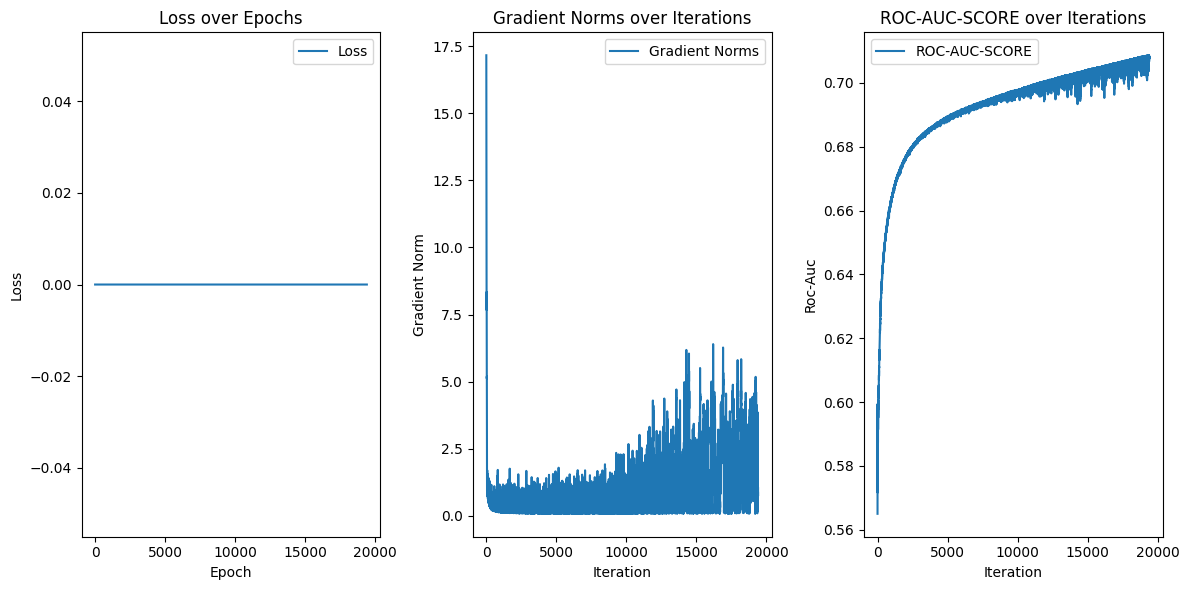

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(gradient_norms, label='Gradient Norms')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Iterations')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(roc_auc_scores, label='ROC-AUC-SCORE')
plt.xlabel('Iteration')
plt.ylabel('Roc-Auc')
plt.title('ROC-AUC-SCORE over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Проверка на отложенном датасете. На train_data_0.pq мы обучались, а на train_data_1.pq тестируем модель. Как видим, модель демонстрирует перфоманс лучше, чем градиентный бустинг. При этом результат около 0.7 был достигнут на остановленной модели. При другом запуске результат был около 0.72.



In [ ]:
df2 = pd.read_parquet('train_data_1.pq')
X_val = df2.groupby('id')[df2.columns.tolist()[2:]].sum().reset_index(drop=True)
X_val = X_val.to_numpy()
y_val = pd.read_csv('train_target.csv', usecols=['flag'])
y_val = y_val[(y_val.index >= df2.id.min()) & (y_val.index <= df2.id.max())].to_numpy()
X_val, y_val = torch.Tensor(X_val), torch.Tensor(y_val)

In [ ]:
model.eval()
with torch.no_grad():
      out_data = model(X_val)
      print('==ROC_AUC_SCORE==')
      a, b = y_val.detach().numpy(), out_data.detach().numpy()
      score = roc_auc_score(a, b)
      print(score)
      print('=================')
      print(confusion_matrix(a, b.round().astype(int)))
      print('=================')

==ROC_AUC_SCORE==
0.6971130860424308
[[152473  89315]
 [  2709   5503]]


Вторая часть: модель с трансформером.

In [ ]:
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, seq_length):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.flatten = nn.Flatten()
        self.seq_length = seq_length
        self.input_dim = input_dim

    def forward(self, X):
        X = X.permute(1, 0, 2)
        X = self.transformer_encoder(X)
        X = X.permute(1, 0, 2)
        X = X.mean(dim=1)
        return X


input_dim = 59
hidden_dim = 64
output_dim = 1
dropout_prob = 0.5
num_heads = 1
num_layers = 2
seq_length = 10


transformer_encoder = SimpleTransformerEncoder(input_dim=input_dim, hidden_dim=hidden_dim,
                                               num_heads=num_heads, num_layers=num_layers,
                                               seq_length=seq_length)

model = nn.Sequential(
    transformer_encoder,
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid()
)

In [ ]:
NUM_EPOCHS = 15000
l1_lambda = 0.001

for epoch in tqdm(range(NUM_EPOCHS)):
    optimizer.zero_grad()


    X_batch, y_batch = random_under_sampling(X_train, y_train)

    output = model(X_batch)
    loss = criterion(output, y_batch)
    losses.append(int(loss))
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss + l1_lambda * l1_norm

    loss.backward()
    optimizer.step()

In [2]:
model.eval()
with torch.no_grad():
      out_data = model(X_val)
      print('==ROC_AUC_SCORE==')
      a, b = y_val.detach().numpy(), out_data.detach().numpy()
      score = roc_auc_score(a, b)
      print(score)
      print('=================')
      print(confusion_matrix(a, b.round().astype(int)))
      print('=================')

==ROC_AUC_SCORE==
0.7831609
[[168012  73776] 
 [  2491   5721]]
